<a href="https://colab.research.google.com/github/darshan-analytics/tweeter_data_analyzer/blob/master/sentimentwithtextblob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Blobber


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [110]:
test_twitter = pd.read_csv("twitter.csv", names=['tweetid','created_at', 'user_name','text','favourite_count','retweet_count', 'location', 'hashtags'])
test_twitter.isna().sum()

tweetid               0
created_at            0
user_name             0
text                  0
favourite_count       0
retweet_count         0
location           1440
hashtags           3405
dtype: int64

In [111]:
train_data_part_one = pd.read_csv('test.csv')
train_data_part_two = pd.read_csv('train.csv')


In [112]:
train = train_data_part_one.append(train_data_part_two, ignore_index=True)
train = train_data_part_one
train['text'] = train['text'].apply(str)
train['sentiment'] = train['sentiment'].apply(str)

In [ ]:
train

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
res = list(tuple(sub) for sub in train) 
res

In [ ]:
!pip install TweetProcessor

In [ ]:
tweet = test.text[25]
blob = TextBlob(tweet)

In [ ]:
blob.sentences

[Sentence("b'RT @PROMOrxTeam: \xe2\x9d\x97\xef\xb8\x8f\xe2\x9d\x97\xef\xb8\x8f\xe2\x9d\x97\xef\xb8\x8f#cybersecurity #InfoSec #infosecurity #tesla Employee Loyalty."),
 Sentence("Wow. '")]

In [115]:
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker
import time
from multiprocessing import  Pool
from nltk.stem import WordNetLemmatizer 


In [76]:
def untokenize(words):
    """Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()


# https://stackoverflow.com/a/47091490
def decontracted(phrase):
    """Convert contractions like "can't" into "can not"
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
        'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
      'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}


def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text

stopwords = [
    "a", "about", "above", "after", "again", "against", "ain", "all", "am",
    "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because",
    "been", "before", "being", "below", "between", "both", "but", "by", "can",
    "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn",
    "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have",
    "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him",
    "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't",
    "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn",
    "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn",
    "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once",
    "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've",
    "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that",
    "that'll", "the", "their", "theirs", "them", "themselves", "then", "there",
    "these", "they", "this", "those", "through", "to", "too", "under", "until",
    "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren",
    "weren't", "what", "when", "where", "which", "while", "who", "whom", "why",
    "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm",
    "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd",
    "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've",
    "what's", "when's", "where's", "who's", "why's", "would", "able", "abst",
    "accordance", "according", "accordingly", "across", "act", "actually",
    "added", "adj", "affected", "affecting", "affects", "afterwards", "ah",
    "almost", "alone", "along", "already", "also", "although", "always",
    "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore",
    "anyone", "anything", "anyway", "anyways", "anywhere", "apparently",
    "approximately", "arent", "arise", "around", "aside", "ask", "asking",
    "auth", "available", "away", "awfully", "b", "back", "became", "become",
    "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings",
    "begins", "behind", "believe", "beside", "besides", "beyond", "biol",
    "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes",
       "certain", "certainly", "co", "com", "come", "comes", "contain",
    "containing", "contains", "couldnt", "date", "different", "done",
    "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty",
    "either", "else", "elsewhere", "end", "ending", "enough", "especially",
    "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything",
    "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five",
    "fix", "followed", "following", "follows", "former", "formerly", "forth",
    "found", "four", "furthermore", "g", "gave", "get", "gets", "getting",
    "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten",
    "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein",
    "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit",
    "however", "hundred", "id", "ie", "im", "immediate", "immediately",
    "importance", "important", "inc", "indeed", "index", "information",
    "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps",
    "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last",
    "lately", "later", "latter", "latterly", "least", "less", "lest", "let",
    "lets", "like", "liked", "likely", "line", "little", "'ll", "look",
    "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may",
    "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might",
    "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug",
    "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly",
    "necessarily", "necessary", "need", "needs", "neither", "never",
    "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none",
    "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere",
    "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old",
    "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside",
    "overall", "owing", "p", "page", "pages", "part", "particular",
    "particularly", "past", "per", "perhaps", "placed", "please", "plus",
    "poorly", "possible", "possibly", "potentially", "pp", "predominantly",
    "present", "previously", "primarily", "probably", "promptly", "proud",
    "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran",
    "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs",
    "regarding", "regardless", "regards", "related", "relatively", "research",
    "respectively", "resulted", "resulting", "results", "right", "run", "said",
    "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem",
    "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven",
    "several", "shall", "shed", "shes", "show", "showed", "shown", "showns",
    "rt","b"
]
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# maybe a bug, it removes question marks?
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_urls(text):
    text = clean(r"http\S+", text)
    text = clean(r"www\S+", text)
    text = clean(r"pic.twitter.com\S+", text)

    return text

def clean(reg_exp, text):
    text = re.sub(reg_exp, " ", text)

    # replace multiple spaces with one.
    text = re.sub('\s{2,}', ' ', text)

    return text

lemmatizer = WordNetLemmatizer()

def clean_all(t, correct_spelling=False, remove_stopwords=False, lemmatize=False):
    
    # first do bulk cleanup on tokens that don't depend on word tokenization

    # remove xml tags
    t = clean(r"<[^>]+>", t)
    t = clean(r"&lt;", t)
    t = clean(r"&gt;", t)

    # remove URLs
    t = remove_urls(t)

    # https://stackoverflow.com/a/35041925
    # replace multiple punctuation with single. Ex: !?!?!? would become ?
    t = clean(r'[\?\.\!]+(?=[\?\.\!])', t)

    t = remove_emoji(t)
    t = decontracted(t)

    # now remove/expand bad patterns per word
    words = word_tokenize(t)

    # remove stopwords
    if remove_stopwords is True:
        words = [w for w in words if not w in stopwords]

    clean_words = []

    for w in words:
        # normalize punctuation
        w = re.sub(r'&', 'and', w)

        # expand slang like OMG = Oh my God
        w = unslang(w)

        if lemmatize is True:
            w = lemmatizer.lemmatize(w)
        
        clean_words.append(w)

    # join the words back into a full string
    t = untokenize(clean_words)

    if correct_spelling is True:
        # this resulted in lots of lost punctuation - omitting for now. Also greatly speeds things up
        t = correct_spellings(t)

    # finally, remove any non ascii and special characters that made it through
    t = clean(r"[^A-Za-z0-9\.\'!\?,\$]", t)

    return t

def clean_dataframe(df, correct_spelling=False, remove_stopwords=False):
    df['clean'] = df.apply(lambda x: clean_all(x['text'], correct_spelling=correct_spelling, remove_stopwords=remove_stopwords), axis=1)

    return df


# https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def parallelize_dataframe(
        df, func, n_cores=2):  # I think Kaggle notebooks only have 2 cores?
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    return df







In [ ]:
train['clean'] = train.apply(lambda x: clean_all(x['text']), axis = 1)
train[['text','clean']]

In [117]:
train['text'] = train['clean']
train = train.drop(columns=['clean'])


In [118]:
test_twitter = parallelize_dataframe(test_twitter, clean_dataframe)
test_twitter['text'] = test_twitter['clean']
test_twitter = test_twitter.drop(columns=['clean'])
test_vader = test_twitter

In [80]:
train['text'] = train['text'].apply(str)

In [81]:
train = train[['text', 'sentiment']].values.tolist()

L = len(train)
train_index = int(0.60 * L)

# split the data into a train and test data
train, test = train[:train_index], train[train_index: ]

In [14]:
cl = NaiveBayesClassifier(train)

In [15]:
test_twitter['text'] = test_twitter['text'].apply(str)

In [16]:
blob = TextBlob("I am happy today", classifier=cl)
blob.sentiment

Sentiment(polarity=0.8, subjectivity=1.0)

In [17]:
import pickle
pickled_classifier_file = open('sentiment_classifier.obj', 'wb')
pickle.dump(cl, pickled_classifier_file)
pickled_classifier_file.close()

In [18]:
cl = pickle.load(open('sentiment_classifier.obj', 'rb'))


In [21]:
tb = Blobber(analyzer=NaiveBayesAnalyzer())



In [22]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:
test_twitter[['nb_sentiment', 'nb_pos', 'nb_neg']] = test_twitter['text'].apply(lambda v: pd.Series(tb(v).sentiment))
test_twitter.head()

In [25]:
test_twitter['nb_sentiment'].replace({"pos":"positive", "neg":"negative"}, inplace=True)

In [ ]:
test_twitter.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f861e431cf8>,
      dtype=object)

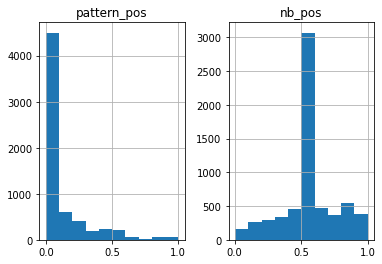

In [27]:
tb = Blobber()
test_twitter[['pattern_polarity', 'pattern_subj']] = test_twitter['text'].apply(lambda v: pd.Series(tb(v).sentiment))
test_twitter['pattern_pos']  = test_twitter.pattern_polarity.abs()

test_twitter[['pattern_pos', 'nb_pos']].hist()

In [ ]:
cl.accuracy(train)

0.9424528301886792

In [ ]:
cl.accuracy(test)

0.5565770862800565

In [ ]:
test_twitter

In [59]:
train_test_twitter = test_twitter[['text', 'nb_sentiment']].values.tolist()

L_test_twitter = len(train_test_twitter)
train_test_index = int(0.60 * L_test_twitter)

# split the data into a train and test data
train_test_twitter, test_test_twitter = train_test_twitter[:train_test_index], train_test_twitter[train_test_index: ]

In [60]:
classify = NaiveBayesClassifier(train_test_twitter)

In [61]:
classify.accuracy(train_test_twitter)

0.7718332022029898

In [62]:
classify.accuracy(test_test_twitter)

0.514948859166011

In [49]:
saving_data = test_twitter.drop(columns=['pattern_polarity','pattern_subj','pattern_pos'])
saving_data.rename(columns={"nb_sentiment":"sentiment","nb_pos":"positive_value","nb_neg":"negative_value"}, inplace=True)

In [50]:
saving_data.to_csv('labelled_data.csv')

In [120]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [121]:
analyser = SentimentIntensityAnalyzer()

In [122]:
text_data = test_vader[['text']]

In [123]:
counter = 0
vader_score = []
while (counter < len(text_data)):
  score = analyser.polarity_scores(text_data.iloc[counter]['text'])
  vader_score.append(score['compound'])
  counter +=1

In [ ]:
test_vader['Vader_scores'] = vader_score


In [125]:
counter = 0

predicted_value = [ ] #empty series to hold our predicted values

while(counter < len(text_data)):
    if ((test_vader.iloc[counter]['Vader_scores'] >= 0.5)):
        predicted_value.append('positive')
        counter +=1
    elif ((test_vader.iloc[counter]['Vader_scores'] > -0.5) & (test_vader.iloc[counter]['Vader_scores'] < 0.5)):
        predicted_value.append('neutral')
        counter +=1
    elif ((test_vader.iloc[counter]['Vader_scores'] <= -0.5)):
        predicted_value.append('negative')
        counter +=1
        

In [126]:
test_vader['sentiment'] = predicted_value
vader_data = test_vader

In [128]:
vader_data.to_csv('Vader_labled_data.csv')

In [98]:
test_vader['sentiment'].value_counts()

positive    3299
neutral     2889
negative     167
Name: sentiment, dtype: int64

In [99]:
test_vader = test_vader[['text', 'sentiment']].values.tolist()

test_vader_length = len(test_vader)
vader_index = int(0.60 * test_vader_length)

# split the data into a train and test data
train_vader , test_vader = test_vader[:vader_index], test_vader[vader_index: ]

In [100]:
vader_classifier = NaiveBayesClassifier(train_vader)

In [101]:
vader_classifier.accuracy(test_vader)

0.8095987411487018

In [102]:
vader_classifier.accuracy(train_vader)

0.9029635457644899